# Chapter 4: LMS-Based Algorithms

## Imports 

In [1]:
import os, sys
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
sources_path = './../'
if sources_path not in sys.path:
    sys.path.append(sources_path)
from adaptive_filtering.lms import SignError, LMSNewton, AffineProjection
from adaptive_filtering.utils import rolling_window, generate_learning_plots

j = complex(0,1)

## Problem 6 and 7

In [54]:
# output_filepath, N = './Outputs/Chap_4/Exercise_6/', 12
output_filepath, N = './Outputs/Chap_4/Exercise_7/', 8
sigma_x2 = 1
sigma_n2 = 1e-3
R = sigma_x2*np.eye(N)
print ('R: {}I'.format(sigma_x2))
mu_max = np.max(np.linalg.eigvals(R))
dirac = lambda l: 1 if l == 0 else 0
p_func = lambda l: 0 if l < 0 else p_func(l-1) + dirac(l)-dirac(l-12)
p = np.array([p_func(l) for l in np.arange(N)])
print ('p: ', p)
mse_min_estimate = sigma_n2
mu_max = (1/np.trace(R))*(np.sqrt(np.pi*mse_min_estimate/2))
print ('mu_max: ', mu_max)

R: 1I
p:  [1 1 1 1 1 1 1 1]
mu_max:  0.004954159122007514


### (b)

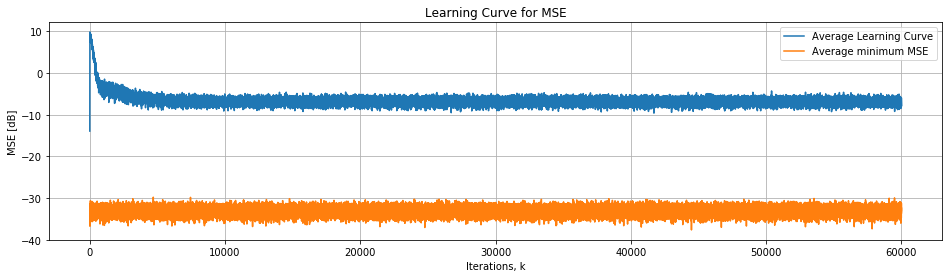

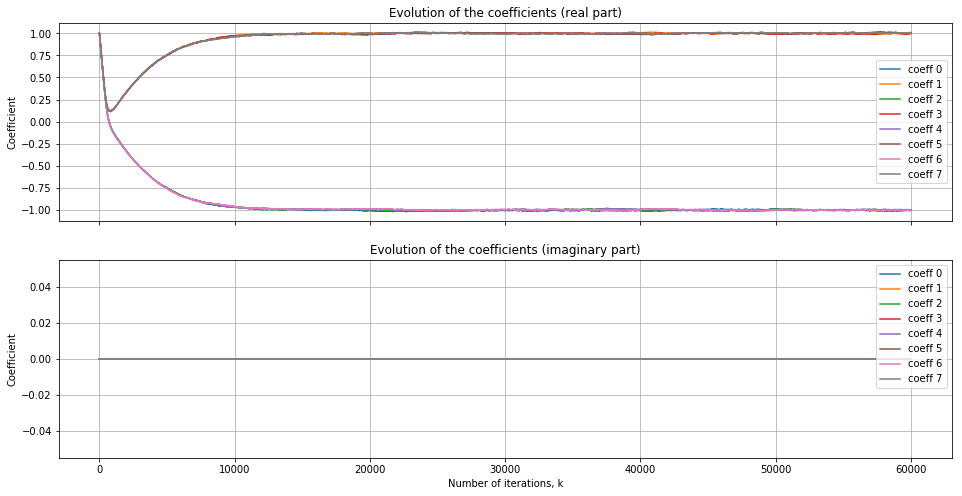

In [61]:
# coefficient vector for each iteration and realization, w[0] = [1, 1, ..., 1]
n_ensembles = 50   # number of realizations within the ensemble
K = 60000   # number of iterations (signal length)
W = np.ones([n_ensembles, K+1, N], dtype=complex) 
MSE = np.zeros([n_ensembles, K]) # MSE vector for each realization
MSE_min = np.zeros([n_ensembles, K]) # Minimum MSE for each realization 
MSE_exc = np.zeros([n_ensembles,K])   
frac = 2
mu = mu_max/frac

def H(x): # Unknown system 
    postfixed_x = np.append(x,np.zeros(12,dtype = complex))
    postfixed_y = np.zeros(len(postfixed_x), dtype = complex)
    for ii in range(0,len(postfixed_x)):
        postfixed_y[ii] = (-1)*postfixed_y[ii-1] + postfixed_x[ii] - postfixed_x[ii-12]
    y = postfixed_y[:len(x)]
    return y

for ensemble in np.arange(n_ensembles):        
    n = np.sqrt(sigma_n2/2)*(np.random.normal(size=K)) # Noise signal
    x = np.sqrt(sigma_x2/2)*(np.random.uniform(size=K))    
    d = H(x)    
    d = d + n

    model = SignError(step=mu, filter_order=N-1, init_coef=np.ones([N]))
    model.fit(d, x)        

    W[ensemble] = model.coef_vector
    MSE[ensemble] = MSE[ensemble] + np.absolute(model.error_vector)**2
    MSE_min[ensemble] = MSE_min[ensemble] + np.absolute(n)**2
    MSE_exc[ensemble] = MSE[ensemble]-MSE_min[ensemble]

W_av = np.sum(W, axis=0)/n_ensembles
MSE_av = sum(MSE, 2)/n_ensembles
MSEmin_av = np.sum(MSE_min, axis=0)/n_ensembles
MSEexc_av = np.sum(MSE_exc, axis=0)/n_ensembles
# Generating plots    
generate_learning_plots(K, N, MSE_av, MSEmin_av, W_av, w_o, output_filepath=output_filepath, algorithm='SignError_mu' + str(frac)) 
    

### (c)

mu_max/2: M_theoretical = 0.7853981633974483


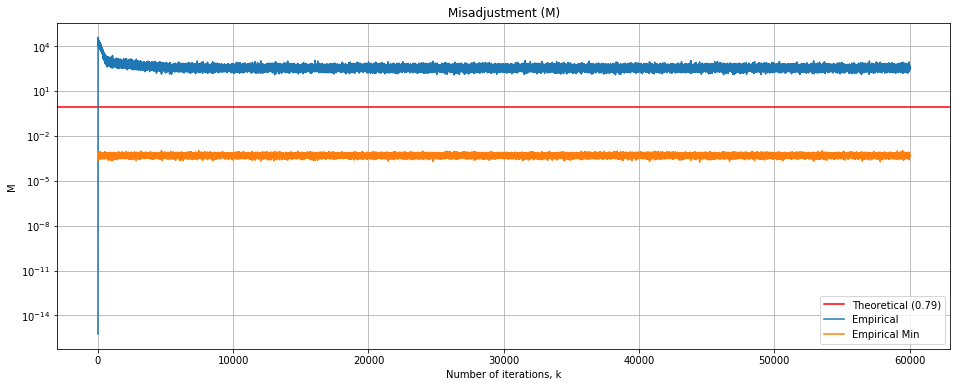

In [62]:
M = lambda mu: mu*np.sqrt(np.pi/(2*mse_min_estimate))*np.trace(R)
m_theoretical = M(mu)
print ('mu_max/{}: M_theoretical = {}'.format(frac, M(mu)))
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
ax.axhline(m_theoretical, c='red', label='Theoretical ({:.02f})'.format(m_theoretical))
ax.plot(np.divide(MSEexc_av,MSEmin_av), label='Empirical')
ax.plot(MSEmin_av, label='Empirical Min')
ax.grid(True)
ax.set_title('Misadjustment (M)'), ax.set_xlabel('Number of iterations, k'), ax.set_ylabel('M')
ax.legend()
ax.set_yscale('log')

if output_filepath is not None:        
    fig.savefig(output_filepath + 'c_misadjustment_mu'+str(frac)+'.jpg', bbox_inches = 'tight')

### (d)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


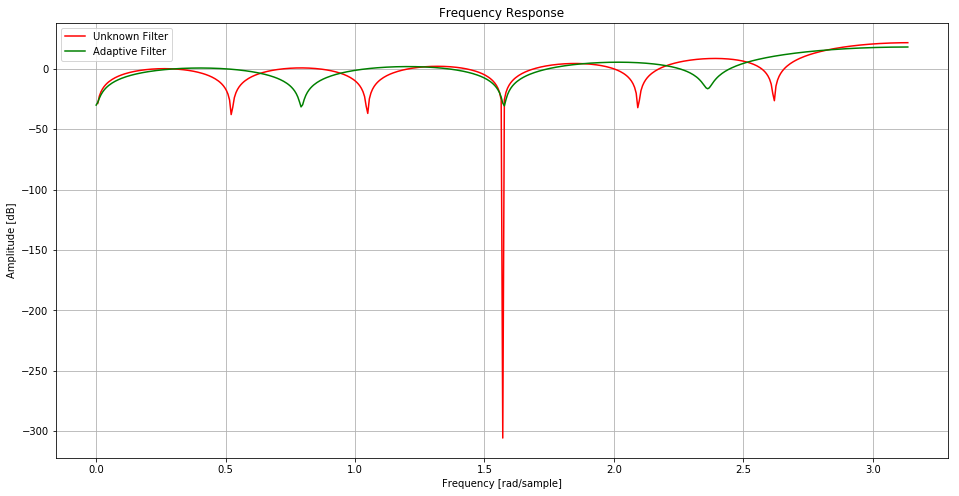

In [63]:
b, a = [1] + list(np.zeros(11)) + [-1], [1, 1] 
wf_model, h_model = signal.freqz(model.coef_vector[-1])
wf_unk, h_unk = signal.freqz(b=b, a=a)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,8))

ax.plot(wf_unk, 20 * np.log10(abs(h_unk)), 'r', label='Unknown Filter')
# ax.plot(wf_o, 20 * np.log10(abs(h_o)), 'b', label='Wiener Filter')
ax.plot(wf_model, 20 * np.log10(abs(h_model)), 'g', label='Adaptive Filter')
ax.set_ylabel('Amplitude [dB]'), ax.set_title('Frequency Response')
ax.set_xlabel('Frequency [rad/sample]')
ax.grid(True)
ax.legend()

if output_filepath is not None:        
    fig.savefig(output_filepath + 'd_frequency_response_mu{}.jpg'.format(frac), bbox_inches = 'tight')

## Problem 8

x(k) is obtained after passing n(k) through the following filter 

$$H_{in}(z) = \frac{X(z)}{N(z)} = \frac{1}{1-0.9z^{-1}}$$

Consequently

$$x(k) = 0.9x(k-1)+n(k)$$

According to Equation (2.83)

$$r(l) = \frac{(0.9)^{|l|}}{1-(-0.9)^2}\sigma_{n_x}^2$$

For $N+1$ = 12 coefficients, $tr[R] = (N+1)r(0) = 31.578$. For the sign-error algorithm, the condition that guarantees both convergence and low-variance in the steady-state is given by 
	
$$ 0 < \mu < \frac{1}{tr[\textbf{R}]} \sqrt{\frac{\pi \xi (k)}{2}} $$

By considering $\xi(k) = \xi_{min} = \sigma_n^2$ (Most strict scenario for $\mu$ considering the minimum measurement error) we have 

In [5]:
output_filepath = './Outputs/Chap_4/Exercise_8/'
model_name = 'SignError'
N = 11+1 # Number of coefficients
sigma_x2 = .5
sigma_n2 = 1e-3
r = lambda l, sigma_n2: (0.9**abs(l))*sigma_n2/(1-0.9**2)
R = np.zeros([N, N])
for i in np.arange(R.shape[0]):
    for j in np.arange(R.shape[1]):
        R[i][j] = r(i-j, sigma_x2)
print ('Trace:', np.trace(R))
mse_estimate = sigma_n2+sigma_x2*((.9)**(N*2))/(1-.9**2)
mse_min_estimate = sigma_n2
mu_max = (1/np.trace(R))*(np.sqrt(np.pi*mse_min_estimate/2))
print ('mu_max: ', mu_max)

Trace: 31.57894736842106
mu_max:  0.0012550536442419034


### (b)

$$ H(z) = \frac{D(z)}{X(z)} = \frac{1-z^{-12}}{1+z^{-1}} $$

$$ d(k) = -d(k-1)+x(k)-x(k-12)  $$

In [6]:
K = 10000 # number of iterations (signal length)
mu = mu_max

def G(x): # Input signal filter before unknown system
        y = np.zeros(len(x), dtype = complex)
        for ii in range(len(x)):
            y[ii] = .9*y[ii-1] + x[ii]
        return y
    
def H(x): # Unknown system 
    postfixed_x = np.append(x,np.zeros(12,dtype = complex))
    postfixed_y = np.zeros(len(postfixed_x), dtype = complex)
    for ii in range(0,len(postfixed_x)):
        postfixed_y[ii] = (-1)*postfixed_y[ii-1] + postfixed_x[ii] - postfixed_x[ii-12]
    y = postfixed_y[:len(x)]
    return y

def run_problem_8(K, mu, model='SignError'):
    d = np.zeros([K]) # Desired signal        
    x = np.zeros([K])
    n_x = np.random.uniform(-1, 1, K)
    n_x = (n_x-n_x.mean())/np.sqrt(n_x.var()/sigma_x2) # Input signal 
    
    x = G(n_x) # Adaptive Filter input signal   
    n = np.random.uniform(-1, 1, K)
    n = (n-n.mean())/np.sqrt(n.var()/sigma_n2) # Measurement noise   
    d = H(x)    
    d = d + n
        
    # Fitting algorithm
    if model == 'SignError':
        from adaptive_filtering.lms import SignError
        model = SignError(step=mu, filter_order=N-1, init_coef=np.ones([N]))
    elif model == 'NLMS':
        from adaptive_filtering.lms import NLMS
        model = NLMS(step=mu, filter_order=N-1, init_coef=np.ones([N]), gamma=1e-10)
    elif model == 'LMSNewton':
        from adaptive_filtering.lms import LMSNewton
        model = LMSNewton(step=mu, filter_order=N-1, init_coef=np.ones([N]), init_inv_rx_hat=None)
    elif model == 'TransformDomainDCT':
        from adaptive_filtering.lms import TransformDomain
        model = TransformDomain(step=mu, matrix='dct', filter_order=N-1, init_power=0, init_coef=np.ones([N]), alpha=.01, gamma=1e-12)
    elif model == 'TransformDomainDFT':
        from adaptive_filtering.lms import TransformDomain
        model = TransformDomain(step=mu, matrix='dft', filter_order=N-1, init_power=0, init_coef=np.ones([N]), alpha=.01, gamma=1e-12)
    elif model == 'AffineProjection':
        from adaptive_filtering.lms import AffineProjection
        model = AffineProjection(step=mu, filter_order=N-1, init_coef=np.ones([N]), memory_length=1)
    
    model.fit(d, x)  
    
    return model, n, x

model, n, x = run_problem_8(K, mu, 'AffineProjection')
print (model)

AffineProjection(step=0.0012550536442419034, filter_order=11, L=1, gamma=0.001)


Wall time: 0 ns


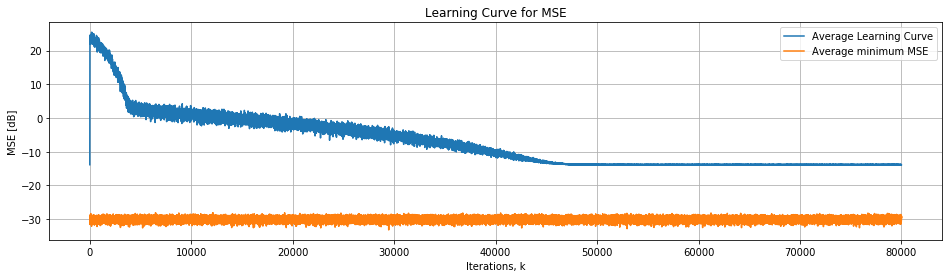

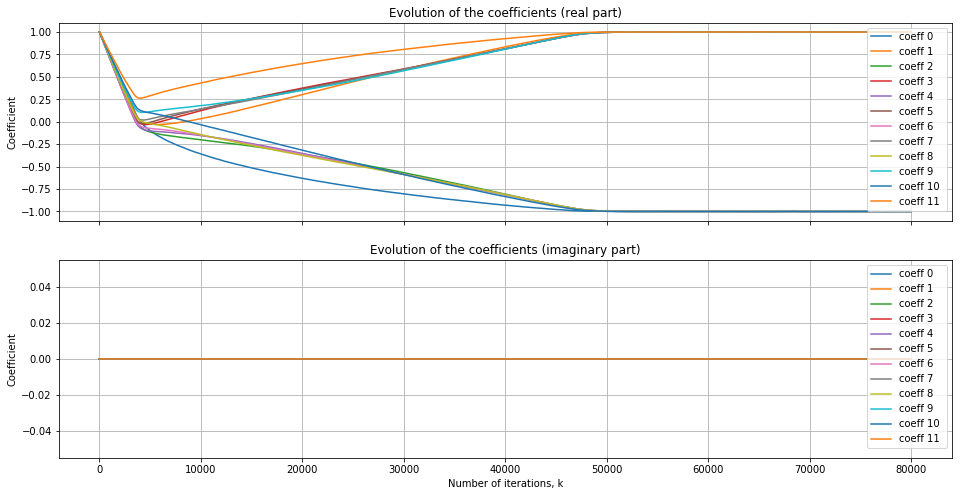

In [30]:
%time
n_ensembles = 50   # number of realizations within the ensemble
K = 80000
W = np.ones([n_ensembles, K+1, N]) 
MSE = np.zeros([n_ensembles, K]) # MSE vector for each realization
MSE_min = np.zeros([n_ensembles,K]) # Minimum MSE for each realization 
MSE_exc = np.zeros([n_ensembles,K])   
frac = 10
mu = mu_max/frac

for ensemble in np.arange(n_ensembles):    
    model, n, x = run_problem_8(K, mu, model=model_name)         

    W[ensemble] = np.real(model.coef_vector)
    MSE[ensemble] = MSE[ensemble] + np.real(np.absolute(model.error_vector)**2)    
    MSE_min[ensemble] = np.abs(n)**2
    MSE_exc[ensemble] = MSE[ensemble]-MSE_min[ensemble]
    
W_av = np.sum(W, axis=0)/n_ensembles
MSE_av = sum(MSE, 2)/n_ensembles
MSEmin_av = np.sum(MSE_min, axis=0)/n_ensembles
MSEexc_av = np.sum(MSE_exc, axis=0)/n_ensembles
# Generating plots    
generate_learning_plots(K, N, MSE_av, MSEmin_av, W_av, None, output_filepath=output_filepath, algorithm='{}_mu{}'.format(model_name, frac))

### (c)

mu_max/10: M_theoretical = 0.15707963267948966


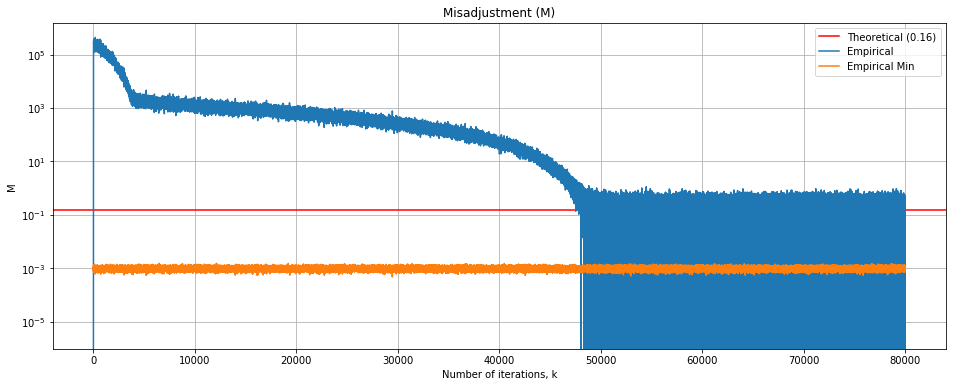

In [31]:
M = lambda mu: mu*np.sqrt(np.pi/(2*mse_min_estimate))*np.trace(R)
m_theoretical = M(mu)
print ('mu_max/{}: M_theoretical = {}'.format(frac, M(mu)))
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
ax.axhline(m_theoretical, c='red', label='Theoretical ({:.02f})'.format(m_theoretical))
ax.plot(np.divide(MSEexc_av,MSEmin_av), label='Empirical')
ax.plot(MSEmin_av, label='Empirical Min')
ax.grid(True)
ax.set_title('Misadjustment (M)'), ax.set_xlabel('Number of iterations, k'), ax.set_ylabel('M')
ax.legend()
ax.set_yscale('log')

if output_filepath is not None:        
    fig.savefig(output_filepath + 'c_misadjustment_mu'+str(frac)+'.jpg', bbox_inches = 'tight')

### (d)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


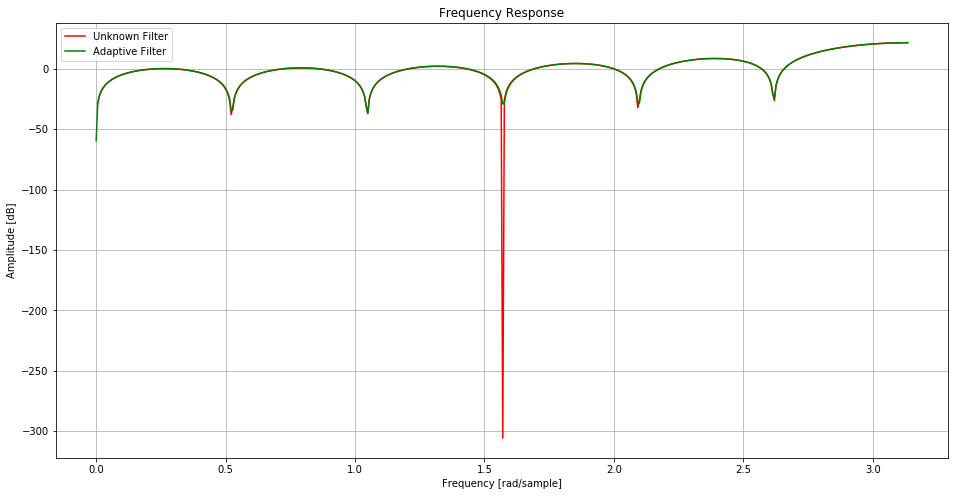

In [29]:
b, a = [1] + list(np.zeros(11)) + [-1], [1, 1] 
wf_model, h_model = signal.freqz(model.coef_vector[-1])
wf_unk, h_unk = signal.freqz(b=b, a=a)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,8))

ax.plot(wf_unk, 20 * np.log10(abs(h_unk)), 'r', label='Unknown Filter')
# ax.plot(wf_o, 20 * np.log10(abs(h_o)), 'b', label='Wiener Filter')
ax.plot(wf_model, 20 * np.log10(abs(h_model)), 'g', label='Adaptive Filter')
ax.set_ylabel('Amplitude [dB]'), ax.set_title('Frequency Response')
ax.set_xlabel('Frequency [rad/sample]')
ax.grid(True)
ax.legend()

if output_filepath is not None:        
    fig.savefig(output_filepath + 'd_frequency_response_mu{}.jpg'.format(frac), bbox_inches = 'tight')

## Problem 10

In [69]:
output_filepath = './Outputs/Chap_4/Exercise_10/'
K = 1000
N = 15
mu = .1
sigma_n2 = 1e-2
h_10 = lambda k: k*np.heaviside(k, 1)-(2*k-9)*np.heaviside(k-5, 1)+(k-9)*np.heaviside(k-10, 1)

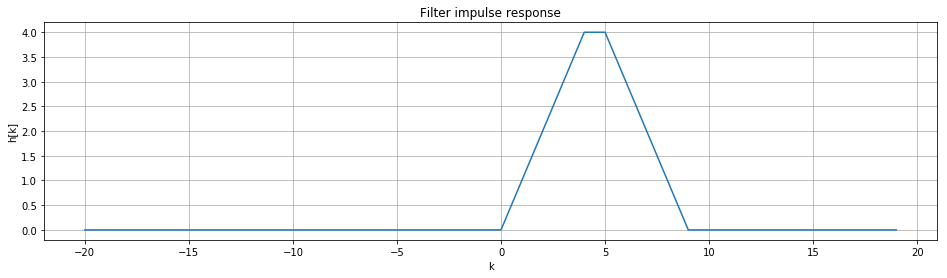

In [70]:
h_length = 20
h = np.zeros(2*h_length)
a = np.arange(-h_length, h_length, 1)
for i, k in enumerate(a):
    h[i] = h_10(k)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,4))
ax.plot(a, h)
ax.grid(True)
ax.set_title('Filter impulse response'), ax.set_xlabel('k'), ax.set_ylabel('h[k]')
if output_filepath is not None:        
    fig.savefig(output_filepath + 'a_unknown_filter_impulse_response.jpg', bbox_inches = 'tight')

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:25: ComplexWarning: Casting complex values to real discards the imaginary part


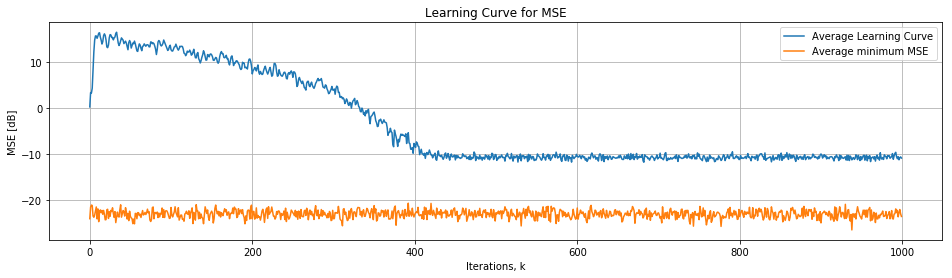

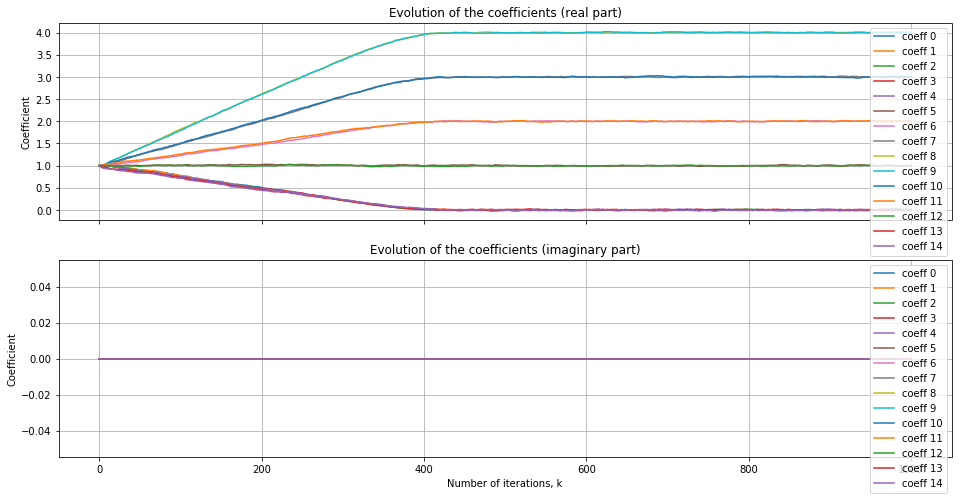

In [71]:
# coefficient vector for each iteration and realization, w[0] = [1, 1, ..., 1]
n_ensembles = 50
W = np.ones([n_ensembles, K+1, N]) 
MSE = np.zeros([n_ensembles, K]) # MSE vector for each realization
MSE_min = np.zeros([n_ensembles, K]) # Minimum MSE for each realization 
MSE_exc = np.zeros([n_ensembles, K]) # Minimum MSE for each realization 
mu = 0.01

for ensemble in np.arange(n_ensembles):    
    d = np.zeros([K]) # Desired signal

    # Creating the input signal (normalized)        
    x = np.sign(np.random.randn(K)) # Input Signal
    n = np.sqrt(sigma_n2/2)*(np.random.normal(size=K)) # Complex noise

    # Convolving h and x
    d = np.convolve(h, x, 'same') + n
    
    init_coef = W[ensemble][0]
    filter_order = N-1    

    model = SignError(step=mu, filter_order=N-1, init_coef=np.ones([N]))
    model.fit(d, x)     

    W[ensemble] = model.coef_vector
    MSE[ensemble] = MSE[ensemble] + np.absolute(model.error_vector)**2
    MSE_min[ensemble] = MSE_min[ensemble] + np.absolute(n)**2
    MSE_exc[ensemble] = MSE[ensemble]-MSE_min[ensemble]

W_av = np.sum(W, axis=0)/n_ensembles
MSE_av = sum(MSE, 2)/n_ensembles
MSEmin_av = np.sum(MSE_min, axis=0)/n_ensembles
MSEexc_av = np.sum(MSE_exc, axis=0)/n_ensembles
# Generating plots    
generate_learning_plots(K, N, MSE_av, MSEmin_av, W_av, w_o, output_filepath=output_filepath, algorithm='SignError') 

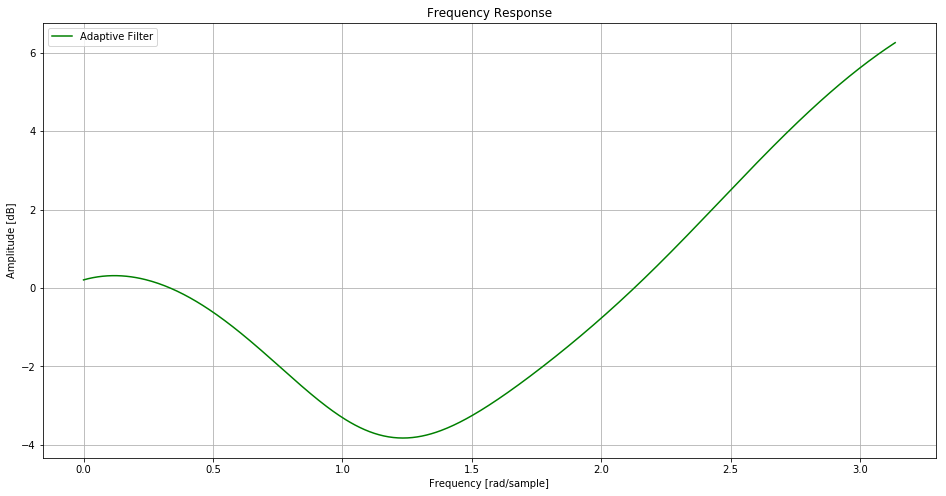

In [72]:
wf_lms, h_lms = signal.freqz(lms.coef_vector[-1])
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,8))
ax.plot(wf_lms, 20 * np.log10(abs(h_lms)), 'g', label='Adaptive Filter')
ax.set_ylabel('Amplitude [dB]'), ax.set_title('Frequency Response')
ax.set_xlabel('Frequency [rad/sample]')
ax.grid(True)
ax.legend()

if output_filepath is not None:        
    fig.savefig(output_filepath + 'a_frequency_response.jpg', bbox_inches = 'tight')

## (b)

C:\Anaconda\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


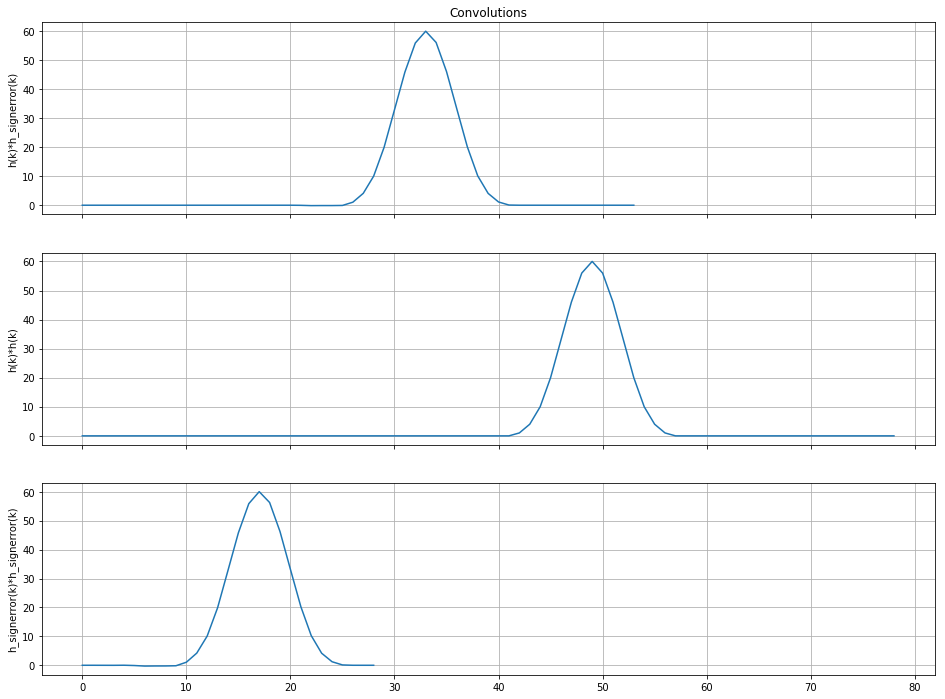

In [73]:
fig, ax = plt.subplots(ncols = 1, nrows=3, figsize=(16,12), sharex=True)
ax[0].plot(np.convolve(model.coef_vector[-1], h))
ax[0].grid(True)
ax[0].set_title('Convolutions'), ax[0].set_ylabel('h(k)*h_signerror(k)')

ax[1].plot(np.convolve(h, h))
ax[1].grid(True)
ax[1].set_ylabel('h(k)*h(k)')

ax[2].plot(np.convolve(model.coef_vector[-1], model.coef_vector[-1]))
ax[2].grid(True)
ax[2].set_ylabel('h_signerror(k)*h_signerror(k)')

if output_filepath is not None:        
    fig.savefig(output_filepath + 'b_convolution.jpg', bbox_inches = 'tight')

## Problem 13 and 14

In [42]:
# output_filepath, lambda_w = './Outputs/Chap_4/Exercise_13/', .999
output_filepath, lambda_w = './Outputs/Chap_4/Exercise_14/', .95
K = 4000
N = 7+1
sigma_x2, sigma_n2, sigma_w2 = .7, .01, .001 
R = sigma_x2*np.eye(N)
mu = .01
model_name='SignError'

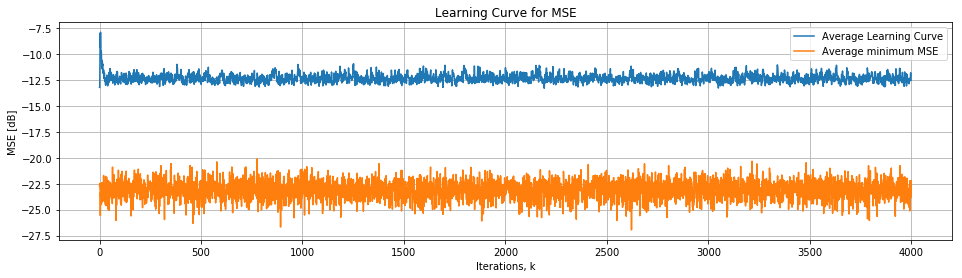

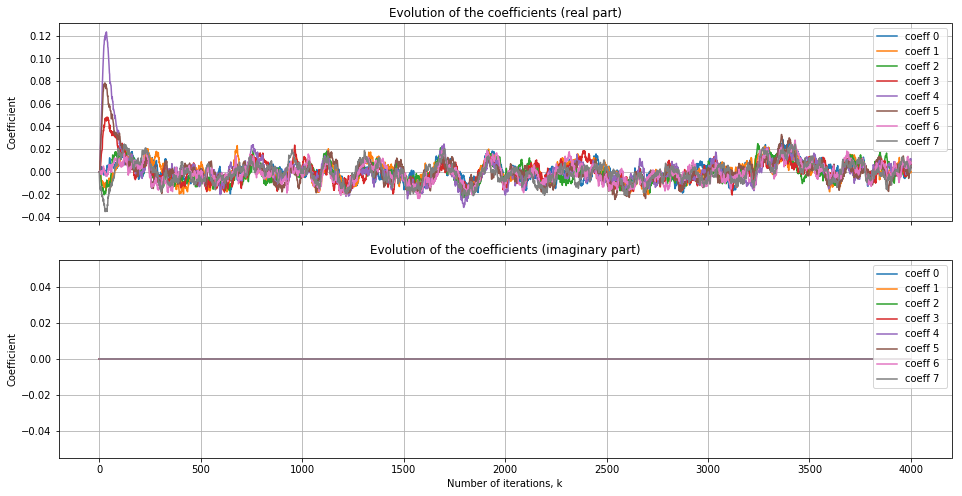

In [43]:
n_ensembles = 50
W = np.zeros([n_ensembles, K+1, N])
W_o = np.zeros([n_ensembles, K+1, N])
MSE = np.zeros([n_ensembles, K])
MSE_min = np.zeros([n_ensembles, K]) # Minimum MSE for each realization 

for ensemble in np.arange(n_ensembles):
    # setting initial w_o
    W_o[ensemble][0] = np.array([0.0349, -0.011, -0.06864, 0.22391, 0.55686, 0.35798, -0.0239, -0.07594])
    n = np.sqrt(sigma_n2/2)*(np.random.normal(size=K)) # Complex noise
    n_w = np.sqrt(sigma_w2/2)*(np.random.normal(size=K)) # Complex noise
    x = np.sqrt(sigma_x2/2)*(np.random.normal(size=K)) # Complex signal
    d = np.zeros(K)
    y = np.zeros(K)
    e = np.zeros(K)

    # Creating a tapped version of x with a N-sized window 
    prefixed_x = np.append(np.zeros([N-1]), x)
    X_tapped = rolling_window(prefixed_x, N)
    for k in np.arange(K):
        d[k] = np.dot(W_o[ensemble][k], X_tapped[k]) + n[k]   
        y[k] = np.dot(W[ensemble][k], X_tapped[k])
        e[k] = d[k]-y[k]
        W[ensemble][k+1] = W[ensemble][k] + 2*mu*np.sign(e[k])*X_tapped[k]    
        W_o[ensemble][k+1] = lambda_w*W_o[ensemble][k] + n_w[k]
        
    MSE[ensemble] = np.abs(e)**2
    MSE_min[ensemble] = np.abs(n)**2     

W_av = np.sum(W, axis=0)/n_ensembles
W_o_av = np.sum(W_o, axis=0)/n_ensembles
MSE_av = sum(MSE, 2)/n_ensembles
MSEmin_av = np.sum(MSE_min, axis=0)/n_ensembles
MSEexc_av = np.sum(MSE-MSE_min, axis=0)/n_ensembles

generate_learning_plots(K, N, MSE_av, MSEmin_av, W_av, None, output_filepath=output_filepath, algorithm='{}'.format(model_name))

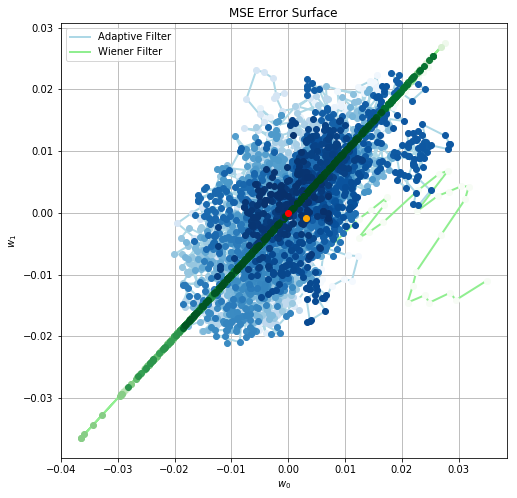

In [44]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

cmap = cm.get_cmap('Blues', K)(np.linspace(0,1,K))[:,:-1]
cmap_o = cm.get_cmap('Greens', K)(np.linspace(0,1,K))[:,:-1]

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,8))
ax.plot(W_av[:,0], W_av[:,1], '-', linewidth=2, color='lightblue', label='Adaptive Filter')
ax.plot(W_o_av[:,0], W_o_av[:,1], '-', linewidth=2, color='lightgreen', label='Wiener Filter')
for k in np.arange(K):
    c_w = 'orange' if k == K-1 else cmap[k]
    c_w_o = 'red' if k == K-1 else cmap_o[k]
    ax.plot(W_av[k,0], W_av[k,1], 'o', linewidth=2, color=c_w)
    ax.plot(W_o_av[k,0], W_o_av[k,1], 'o', linewidth=2, color=c_w_o)

ax.set_xlabel('$w_0$'), ax.set_ylabel('$w_1$'), ax.set_title('MSE Error Surface')
ax.grid(True)
ax.legend()
# if output_filepath is not None:    
#     if not os.path.exists(output_filepath):
#         os.makedirs(output_filepath)
#     fig.savefig(output_filepath + 'b_convergence_path.jpg', bbox_inches = 'tight')

## Problem 22

**For the setup described in problem 8, choose an appropriate $\mu$ and run the LMS-Newton algorithm**.

According to Equation (2.83)

$$r(l) = \frac{(0.9)^{|l|}}{1-(-0.9)^2}\sigma_{n_x}^2$$

For $N+1$ = 12 coefficients, $tr[R] = (N+1)r(0) = 31.578$. By setting the following condition
	
$$ 0 < \mu < \frac{1}{tr[\textbf{R}]} = 0.03167$$

We choose $\mu = 0.01$



In [33]:
output_filepath = './Outputs/Chap_4/Exercise_22/'
model_name = 'LMSNewton'
N = 11+1 # Number of coefficients
sigma_x2 = .5
sigma_n2 = 1e-3
r = lambda l, sigma_n2: (0.9**abs(l))*sigma_n2/(1-0.9**2)
R = np.zeros([N, N])
for i in np.arange(R.shape[0]):
    for j in np.arange(R.shape[1]):
        R[i][j] = r(i-j, sigma_x2)
print ('Trace:', np.trace(R))
mse_estimate = sigma_n2+sigma_x2*((.9)**(N*2))/(1-.9**2)
mse_min_estimate = sigma_n2
mu_max = (1/np.trace(R))
print ('mu_max: ', mu_max)
mu = 0.03
print ('mu: ', mu)

Trace: 31.57894736842106
mu_max:  0.03166666666666666
mu:  0.03


Wall time: 0 ns


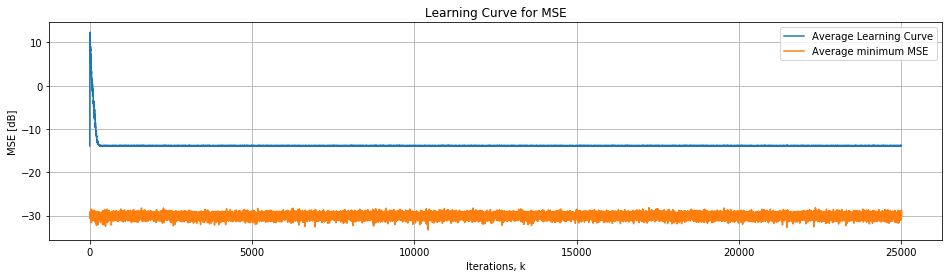

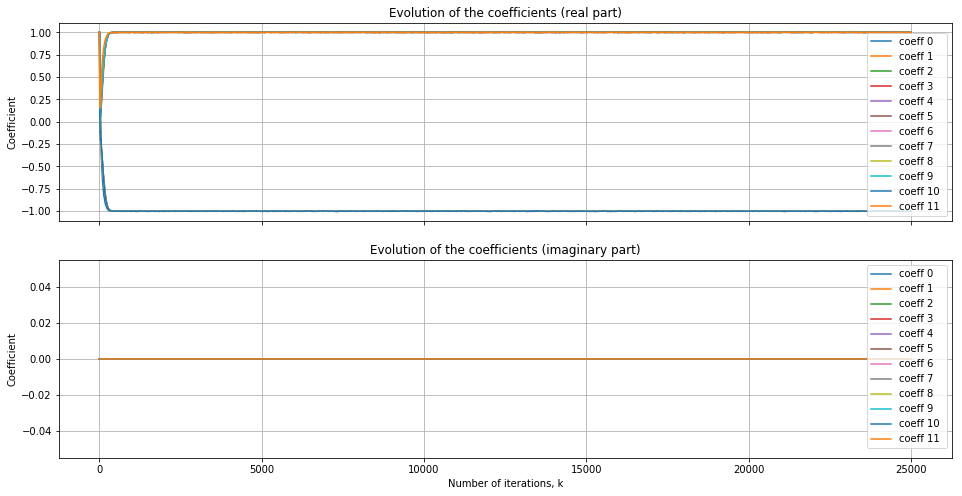

In [34]:
%time
n_ensembles = 50   # number of realizations within the ensemble
K = 25000
W = np.ones([n_ensembles, K+1, N]) 
MSE = np.zeros([n_ensembles, K]) # MSE vector for each realization
MSE_min = np.zeros([n_ensembles,K]) # Minimum MSE for each realization 
MSE_exc = np.zeros([n_ensembles,K])   

for ensemble in np.arange(n_ensembles):    
    model, n, x = run_problem_8(K, mu, model=model_name)         

    W[ensemble] = np.real(model.coef_vector)
    MSE[ensemble] = MSE[ensemble] + np.real(np.absolute(model.error_vector)**2)    
    MSE_min[ensemble] = np.abs(n)**2
    MSE_exc[ensemble] = MSE[ensemble]-MSE_min[ensemble]
    
W_av = np.sum(W, axis=0)/n_ensembles
MSE_av = sum(MSE, 2)/n_ensembles
MSEmin_av = np.sum(MSE_min, axis=0)/n_ensembles
MSEexc_av = np.sum(MSE_exc, axis=0)/n_ensembles
# Generating plots    
generate_learning_plots(K, N, MSE_av, MSEmin_av, W_av, None, output_filepath=output_filepath, algorithm='{}_muMax{}'.format(model_name, factor))

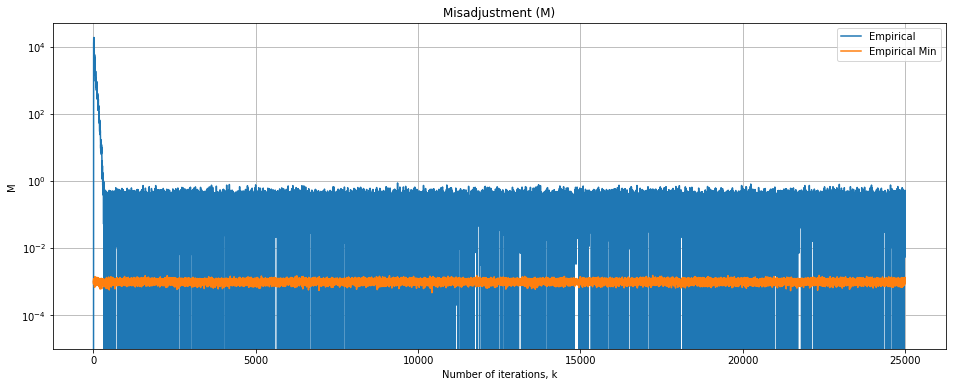

In [35]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
ax.plot(np.divide(MSEexc_av,MSEmin_av), label='Empirical')
ax.plot(MSEmin_av, label='Empirical Min')
ax.grid(True)
ax.set_title('Misadjustment (M)'), ax.set_xlabel('Number of iterations, k'), ax.set_ylabel('M')
ax.legend()
ax.set_yscale('log')

if output_filepath is not None:        
    fig.savefig(output_filepath + 'c_misadjustment.jpg', bbox_inches = 'tight')

### (b) 

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


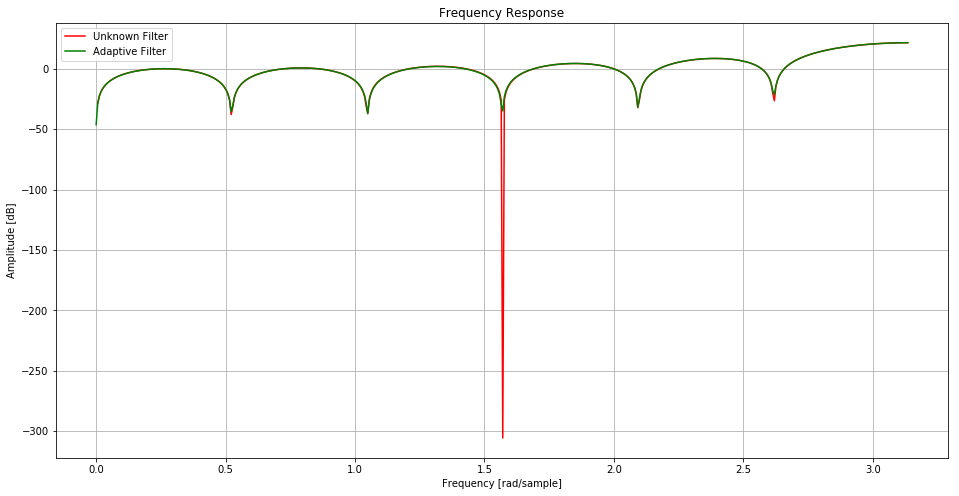

In [36]:
b, a = [1] + list(np.zeros(11)) + [-1], [1, 1] 
wf_model, h_model = signal.freqz(model.coef_vector[-1])
wf_unk, h_unk = signal.freqz(b=b, a=a)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,8))
ax.plot(wf_unk, 20 * np.log10(abs(h_unk)), 'r', label='Unknown Filter')
ax.plot(wf_model, 20 * np.log10(abs(h_model)), 'g', label='Adaptive Filter')
ax.set_ylabel('Amplitude [dB]'), ax.set_title('Frequency Response')
ax.set_xlabel('Frequency [rad/sample]')
ax.grid(True)
ax.legend()

if output_filepath is not None:        
    fig.savefig(output_filepath + 'd_frequency_response.jpg', bbox_inches = 'tight')

## Problem 23

For the NLMS algorithm, 

$$ 0 < \mu < \frac{1}{tr[\textbf{R}]} = 0.03167$$

In [67]:
output_filepath = './Outputs/Chap_4/Exercise_23/'
model_name = 'NLMS'
N = 11+1 # Number of coefficients
sigma_x2 = .5
sigma_n2 = 1e-3
r = lambda l, sigma_n2: (0.9**abs(l))*sigma_n2/(1-0.9**2)
R = np.zeros([N, N])
for i in np.arange(R.shape[0]):
    for j in np.arange(R.shape[1]):
        R[i][j] = r(i-j, sigma_x2)
print ('Trace:', np.trace(R))
mse_estimate = sigma_n2+sigma_x2*((.9)**(N*2))/(1-.9**2)
mse_min_estimate = sigma_n2
mu_max = (1/np.trace(R))
print ('mu_max: ', mu_max)

Trace: 31.57894736842106
mu_max:  0.03166666666666666


### (b)

Wall time: 0 ns


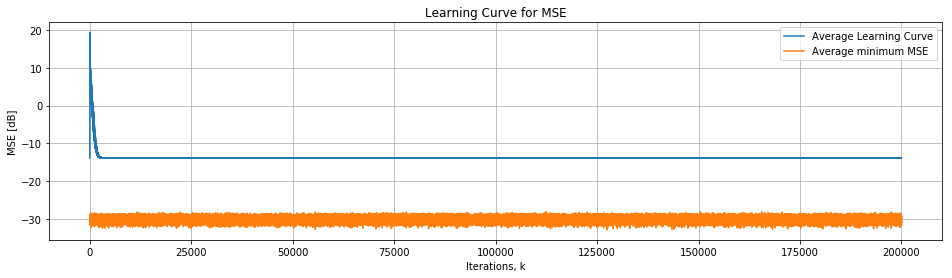

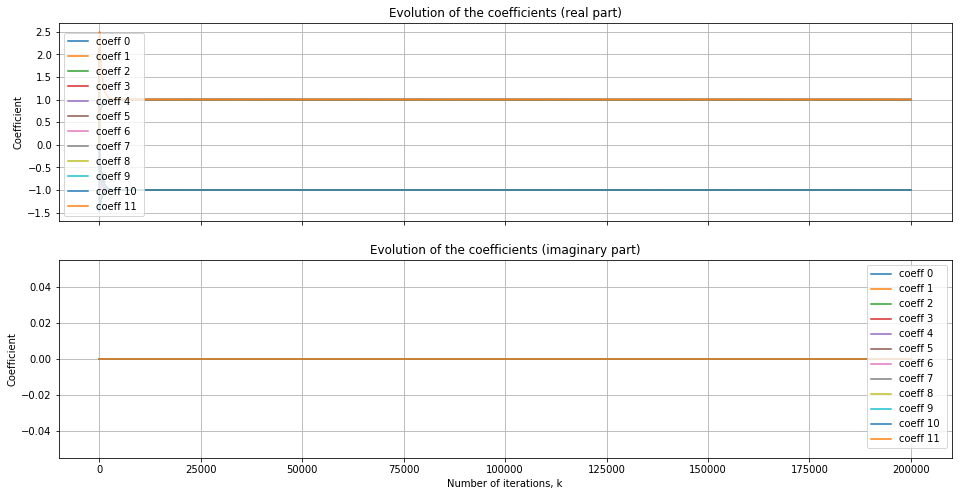

In [13]:
%time
n_ensembles = 50   # number of realizations within the ensemble
K = 200000
W = np.ones([n_ensembles, K+1, N]) 
MSE = np.zeros([n_ensembles, K]) # MSE vector for each realization
MSE_min = np.zeros([n_ensembles,K]) # Minimum MSE for each realization 
MSE_exc = np.zeros([n_ensembles,K])   
frac = 10
mu = mu_max/frac

for ensemble in np.arange(n_ensembles):    
    model, n, x = run_problem_8(K, mu, model=model_name)         

    W[ensemble] = np.real(model.coef_vector)
    MSE[ensemble] = MSE[ensemble] + np.real(np.absolute(model.error_vector)**2)    
    MSE_min[ensemble] = np.abs(n)**2
    MSE_exc[ensemble] = MSE[ensemble]-MSE_min[ensemble]
    
W_av = np.sum(W, axis=0)/n_ensembles
MSE_av = sum(MSE, 2)/n_ensembles
MSEmin_av = np.sum(MSE_min, axis=0)/n_ensembles
MSEexc_av = np.sum(MSE_exc, axis=0)/n_ensembles
# Generating plots    
generate_learning_plots(K, N, MSE_av, MSEmin_av, W_av, None, output_filepath=output_filepath, algorithm='{}_mu{}'.format(model_name, frac))

### (c)

mu_max/10: M_theoretical = 3.96332729760601


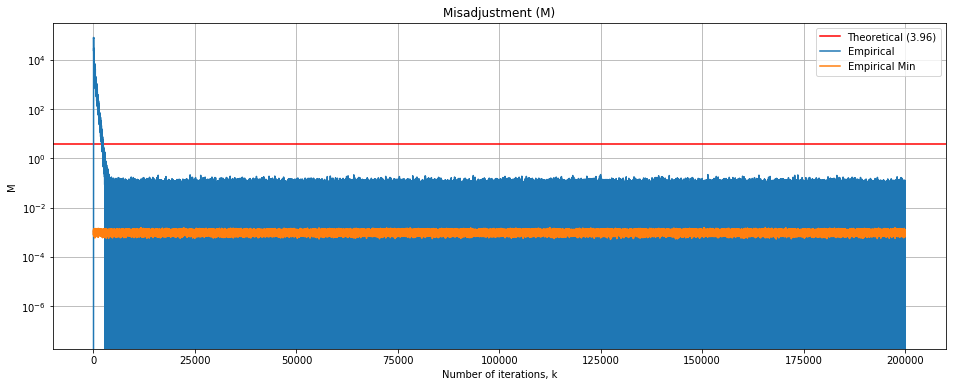

In [14]:
M = lambda mu: mu*np.sqrt(np.pi/(2*mse_min_estimate))*np.trace(R)
m_theoretical = M(mu)
print ('mu_max/{}: M_theoretical = {}'.format(frac, M(mu)))
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
ax.axhline(m_theoretical, c='red', label='Theoretical ({:.02f})'.format(m_theoretical))
ax.plot(np.divide(MSEexc_av,MSEmin_av), label='Empirical')
ax.plot(MSEmin_av, label='Empirical Min')
ax.grid(True)
ax.set_title('Misadjustment (M)'), ax.set_xlabel('Number of iterations, k'), ax.set_ylabel('M')
ax.legend()
ax.set_yscale('log')

if output_filepath is not None:        
    fig.savefig(output_filepath + 'c_misadjustment_mu'+str(frac)+'.jpg', bbox_inches = 'tight')

### (d)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


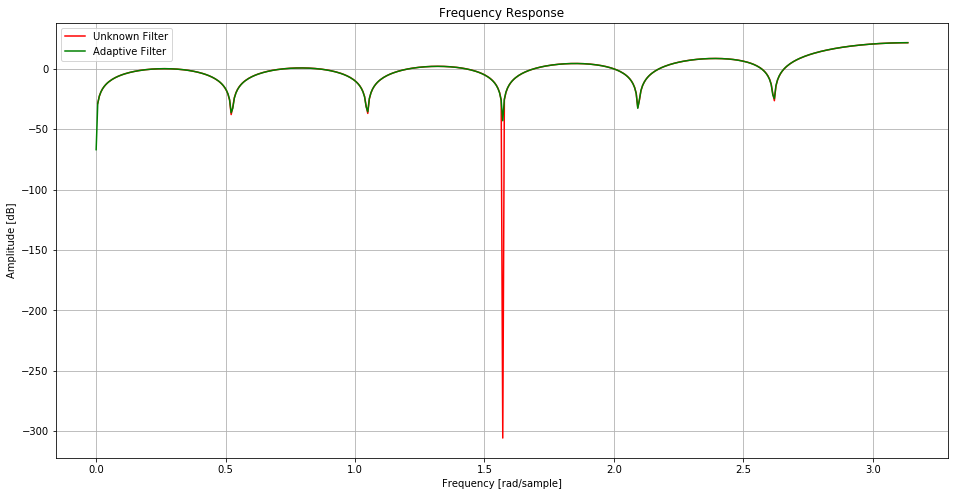

In [15]:
b, a = [1] + list(np.zeros(11)) + [-1], [1, 1] 
wf_model, h_model = signal.freqz(model.coef_vector[-1])
wf_unk, h_unk = signal.freqz(b=b, a=a)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,8))
ax.plot(wf_unk, 20 * np.log10(abs(h_unk)), 'r', label='Unknown Filter')
ax.plot(wf_model, 20 * np.log10(abs(h_model)), 'g', label='Adaptive Filter')
ax.set_ylabel('Amplitude [dB]'), ax.set_title('Frequency Response')
ax.set_xlabel('Frequency [rad/sample]')
ax.grid(True)
ax.legend()

if output_filepath is not None:        
    fig.savefig(output_filepath + 'd_frequency_response_mu{}.jpg'.format(frac), bbox_inches = 'tight')

## Problem 24

Repeat problem 8 using the transform-domain LMS algorithm with DFT. Compare the results with those obtained with the standard LMS algorithm.

In [45]:
output_filepath = './Outputs/Chap_4/Exercise_24/'
model_name = 'TransformDomainDFT'
N = 11+1 # Number of coefficients
sigma_x2 = .5
sigma_n2 = 1e-3
r = lambda l, sigma_n2: (0.9**abs(l))*sigma_n2/(1-0.9**2)
R = np.zeros([N, N])
for i in np.arange(R.shape[0]):
    for j in np.arange(R.shape[1]):
        R[i][j] = r(i-j, sigma_x2)
print ('Trace:', np.trace(R))
mse_estimate = sigma_n2+sigma_x2*((.9)**(N*2))/(1-.9**2)
mse_min_estimate = sigma_n2
mu_max = 1/np.trace(R)
print (mu_max)

Trace: 31.57894736842106
0.03166666666666666


## (b)

Wall time: 0 ns


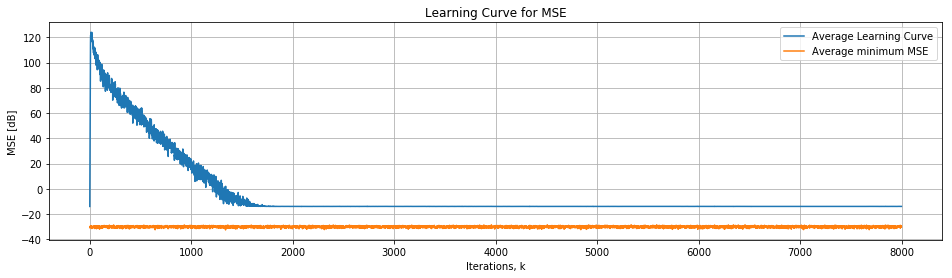

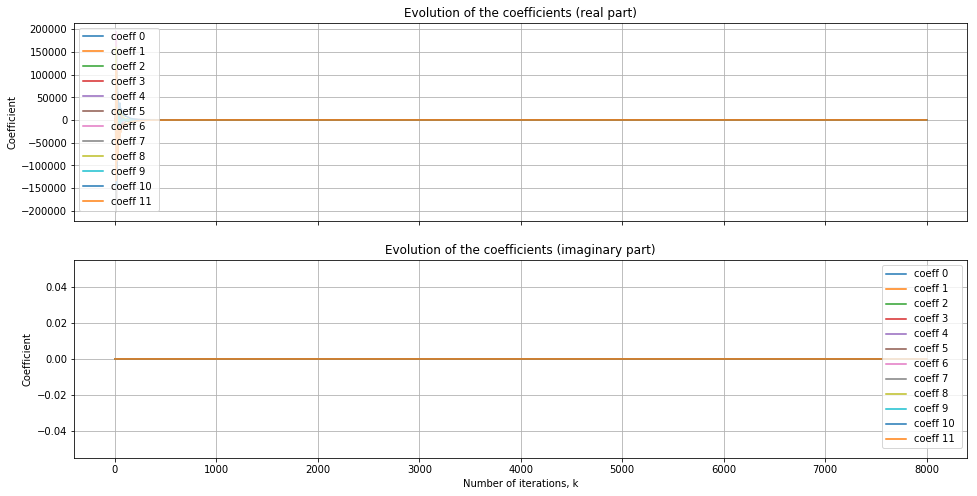

In [65]:
%time
n_ensembles = 50   # number of realizations within the ensemble
K = 8000
W = np.ones([n_ensembles, K+1, N]) 
MSE = np.zeros([n_ensembles, K]) # MSE vector for each realization
MSE_min = np.zeros([n_ensembles,K]) # Minimum MSE for each realization 
MSE_exc = np.zeros([n_ensembles,K])   
frac = 2
mu = mu_max/frac

for ensemble in np.arange(n_ensembles):    
    model, n, x = run_problem_8(K, mu, model=model_name)         

    W[ensemble] = np.real(model.coef_vector)
    MSE[ensemble] = MSE[ensemble] + np.real(np.absolute(model.error_vector)**2)    
    MSE_min[ensemble] = np.abs(n)**2
    MSE_exc[ensemble] = MSE[ensemble]-MSE_min[ensemble]
    
W_av = np.sum(W, axis=0)/n_ensembles
MSE_av = sum(MSE, 2)/n_ensembles
MSEmin_av = np.sum(MSE_min, axis=0)/n_ensembles
MSEexc_av = np.sum(MSE_exc, axis=0)/n_ensembles
# Generating plots    
generate_learning_plots(K, N, MSE_av, MSEmin_av, W_av, None, output_filepath=output_filepath, algorithm='{}_muMax{}'.format(model_name, frac))

## (c)

mu_max/2: M_theoretical = 19.816636488030053


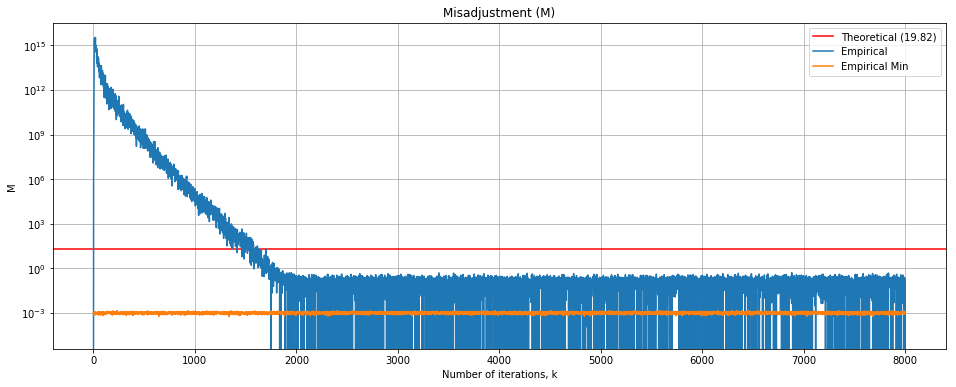

In [66]:
M = lambda mu: mu*np.sqrt(np.pi/(2*mse_min_estimate))*np.trace(R)
m_theoretical = M(mu)
print ('mu_max/{}: M_theoretical = {}'.format(frac, M(mu)))
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
ax.axhline(m_theoretical, c='red', label='Theoretical ({:.02f})'.format(m_theoretical))
ax.plot(np.divide(MSEexc_av,MSEmin_av), label='Empirical')
ax.plot(MSEmin_av, label='Empirical Min')
ax.grid(True)
ax.set_title('Misadjustment (M)'), ax.set_xlabel('Number of iterations, k'), ax.set_ylabel('M')
ax.legend()
ax.set_yscale('log')

if output_filepath is not None:        
    fig.savefig(output_filepath + 'c_misadjustment_mu'+str(frac)+'.jpg', bbox_inches = 'tight')

## (d)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


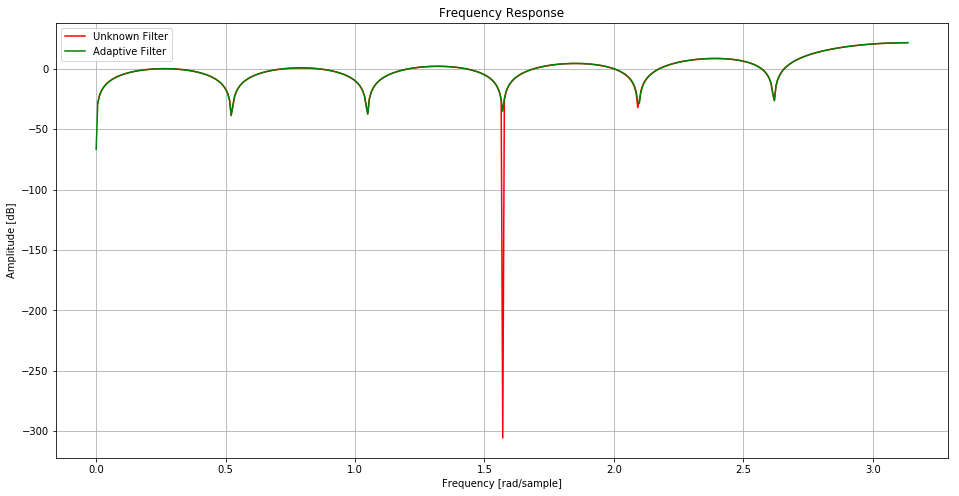

In [67]:
b, a = [1] + list(np.zeros(11)) + [-1], [1, 1] 
wf_model, h_model = signal.freqz(model.coef_vector[-1])
wf_unk, h_unk = signal.freqz(b=b, a=a)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,8))
ax.plot(wf_unk, 20 * np.log10(abs(h_unk)), 'r', label='Unknown Filter')
ax.plot(wf_model, 20 * np.log10(abs(h_model)), 'g', label='Adaptive Filter')
ax.set_ylabel('Amplitude [dB]'), ax.set_title('Frequency Response')
ax.set_xlabel('Frequency [rad/sample]')
ax.grid(True)
ax.legend()

if output_filepath is not None:        
    fig.savefig(output_filepath + 'd_frequency_response_mu{}.jpg'.format(frac), bbox_inches = 'tight')

## Problem 25

Repeat problem 8 using the Affine-projection algorithm

In [7]:
output_filepath = './Outputs/Chap_4/Exercise_25/'
model_name = 'AffineProjection'
N = 11+1 # Number of coefficients
L = 1
sigma_x2 = .5
sigma_n2 = 1e-3
r = lambda l, sigma_n2: (0.9**abs(l))*sigma_n2/(1-0.9**2)
R = np.zeros([N, N])
for i in np.arange(R.shape[0]):
    for j in np.arange(R.shape[1]):
        R[i][j] = r(i-j, sigma_x2)
print ('Trace:', np.trace(R))
mse_estimate = sigma_n2+sigma_x2*((.9)**(N*2))/(1-.9**2)
mse_min_estimate = sigma_n2
mu_max = 1/np.trace(R)
print (mu_max)

Trace: 31.57894736842106
0.03166666666666666


## (b)

Wall time: 0 ns


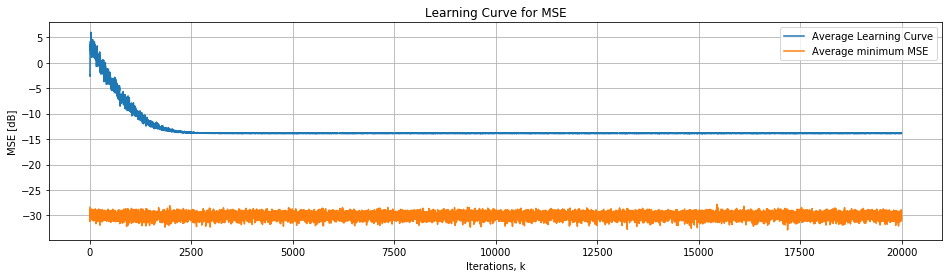

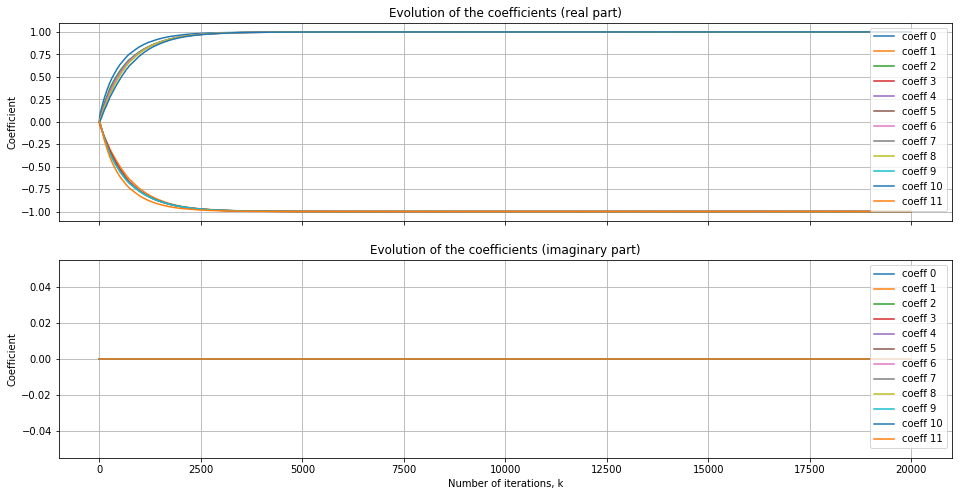

In [24]:
%time
n_ensembles = 50   # number of realizations within the ensemble
K = 20000
W = np.ones([n_ensembles, K+1, N]) 
MSE = np.zeros([n_ensembles, K]) # MSE vector for each realization
MSE_min = np.zeros([n_ensembles,K]) # Minimum MSE for each realization 
MSE_exc = np.zeros([n_ensembles,K])   
frac = 2
mu = mu_max/frac

for ensemble in np.arange(n_ensembles):    
    model, n, x = run_problem_8(K, mu, model=model_name)         

    W[ensemble] = np.real(model.coef_vector)
    MSE[ensemble] = MSE[ensemble] + np.real(np.absolute(model.error_vector)**2)    
    MSE_min[ensemble] = np.abs(n)**2
    MSE_exc[ensemble] = MSE[ensemble]-MSE_min[ensemble]
    
W_av = np.sum(W, axis=0)/n_ensembles
MSE_av = sum(MSE, 2)/n_ensembles
MSEmin_av = np.sum(MSE_min, axis=0)/n_ensembles
MSEexc_av = np.sum(MSE_exc, axis=0)/n_ensembles
# Generating plots    
generate_learning_plots(K, N, MSE_av, MSEmin_av, W_av, None, output_filepath=output_filepath, algorithm='{}_muMax{}'.format(model_name, frac))

## (c)

mu_max/2: M_theoretical = 0.008107187999691245


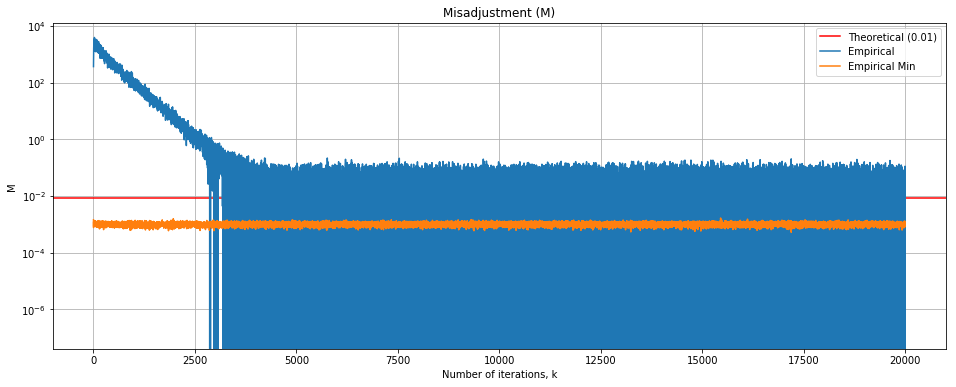

In [25]:

m_theoretical = ((L+1)*mu/(2-mu))*((1-(1-mu)**2)/(1-(1-mu)**(2*(L+1))))
print ('mu_max/{}: M_theoretical = {}'.format(frac, m_theoretical))
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
ax.axhline(m_theoretical, c='red', label='Theoretical ({:.02f})'.format(m_theoretical))
ax.plot(np.divide(MSEexc_av,MSEmin_av), label='Empirical')
ax.plot(MSEmin_av, label='Empirical Min')
ax.grid(True)
ax.set_title('Misadjustment (M)'), ax.set_xlabel('Number of iterations, k'), ax.set_ylabel('M')
ax.legend()
ax.set_yscale('log')

if output_filepath is not None:        
    fig.savefig(output_filepath + 'c_misadjustment_mu'+str(frac)+'.jpg', bbox_inches = 'tight')

## (d)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


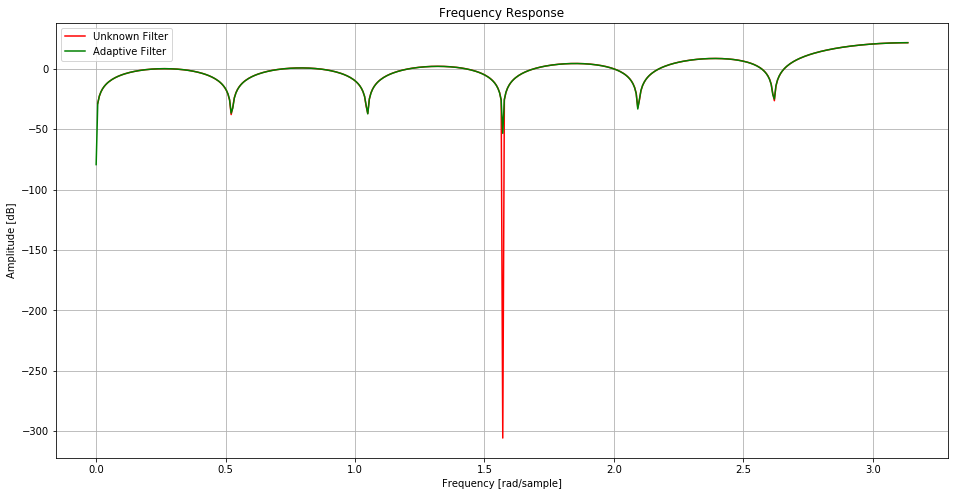

In [26]:
b, a = [1] + list(np.zeros(11)) + [-1], [1, 1] 
wf_model, h_model = signal.freqz(model.coef_vector[-1])
wf_unk, h_unk = signal.freqz(b=b, a=a)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,8))
ax.plot(wf_unk, 20 * np.log10(abs(h_unk)), 'r', label='Unknown Filter')
ax.plot(wf_model, 20 * np.log10(abs(h_model)), 'g', label='Adaptive Filter')
ax.set_ylabel('Amplitude [dB]'), ax.set_title('Frequency Response')
ax.set_xlabel('Frequency [rad/sample]')
ax.grid(True)
ax.legend()

if output_filepath is not None:        
    fig.savefig(output_filepath + 'd_frequency_response_mu{}.jpg'.format(frac), bbox_inches = 'tight')

## Problem 26

Repeat problem 8 using the transform-domain LMS algorithm with DCT. 

In [55]:
output_filepath = './Outputs/Chap_4/Exercise_26/'
model_name = 'TransformDomainDCT'
N = 11+1 # Number of coefficients
sigma_x2 = .5
sigma_n2 = 1e-3
r = lambda l, sigma_n2: (0.9**abs(l))*sigma_n2/(1-0.9**2)
R = np.zeros([N, N])
for i in np.arange(R.shape[0]):
    for j in np.arange(R.shape[1]):
        R[i][j] = r(i-j, sigma_x2)
print ('Trace:', np.trace(R))
mse_estimate = sigma_n2+sigma_x2*((.9)**(N*2))/(1-.9**2)
mse_min_estimate = sigma_n2
mu_max = 1/np.trace(R)
print (mu_max)

Trace: 31.57894736842106
0.03166666666666666


## (b)

Wall time: 0 ns


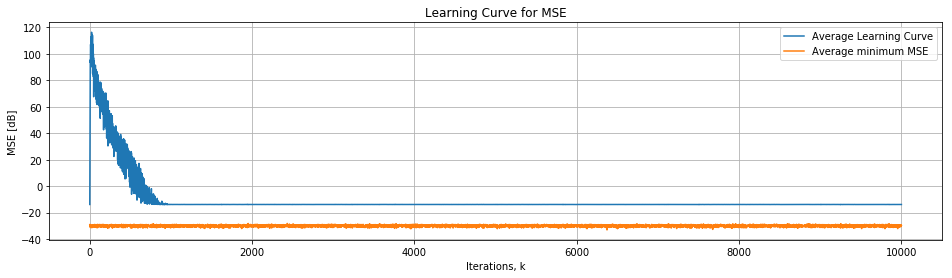

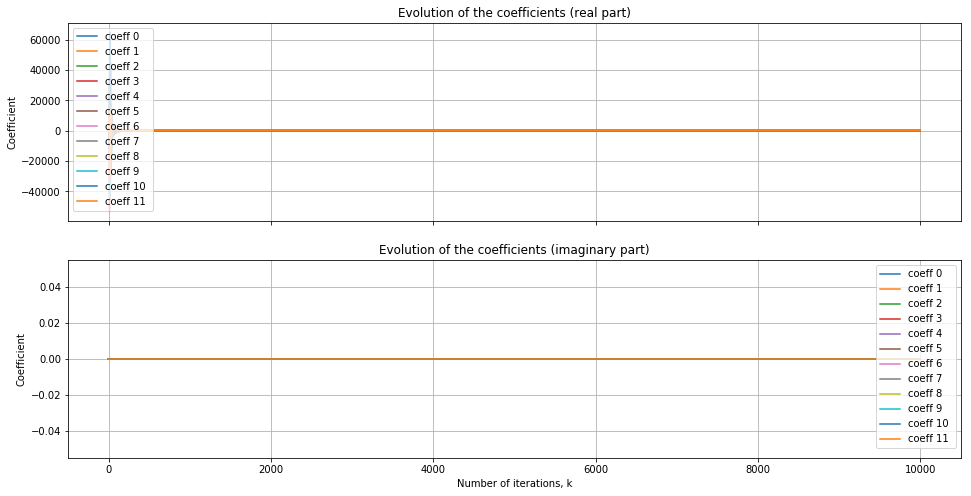

In [63]:
%time
n_ensembles = 50   # number of realizations within the ensemble
K = 10000
W = np.ones([n_ensembles, K+1, N]) 
MSE = np.zeros([n_ensembles, K]) # MSE vector for each realization
MSE_min = np.zeros([n_ensembles,K]) # Minimum MSE for each realization 
MSE_exc = np.zeros([n_ensembles,K])   
frac = 2
mu = mu_max/frac

for ensemble in np.arange(n_ensembles):    
    model, n, x = run_problem_8(K, mu, model=model_name)         

    W[ensemble] = np.real(model.coef_vector)
    MSE[ensemble] = MSE[ensemble] + np.real(np.absolute(model.error_vector)**2)    
    MSE_min[ensemble] = np.abs(n)**2
    MSE_exc[ensemble] = MSE[ensemble]-MSE_min[ensemble]
    
W_av = np.sum(W, axis=0)/n_ensembles
MSE_av = sum(MSE, 2)/n_ensembles
MSEmin_av = np.sum(MSE_min, axis=0)/n_ensembles
MSEexc_av = np.sum(MSE_exc, axis=0)/n_ensembles
# Generating plots    
generate_learning_plots(K, N, MSE_av, MSEmin_av, W_av, None, output_filepath=output_filepath, algorithm='{}_muMax{}'.format(model_name, frac))

## (c)

mu_max/2: M_theoretical = 19.816636488030053


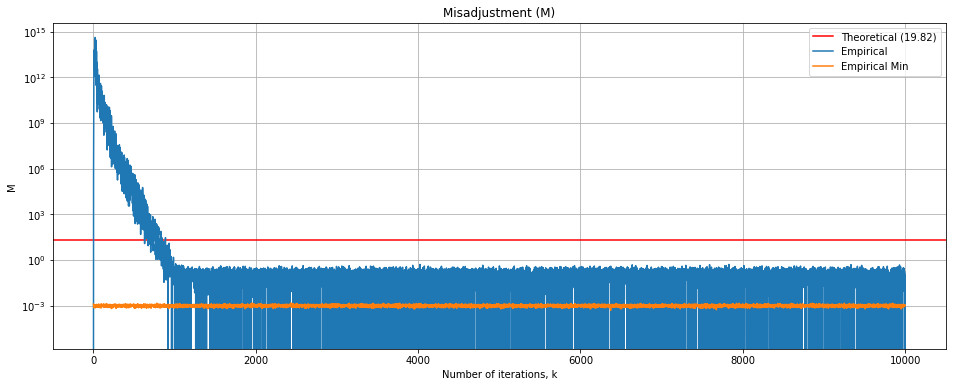

In [64]:
M = lambda mu: mu*np.sqrt(np.pi/(2*mse_min_estimate))*np.trace(R)
m_theoretical = M(mu)
print ('mu_max/{}: M_theoretical = {}'.format(frac, M(mu)))
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
ax.axhline(m_theoretical, c='red', label='Theoretical ({:.02f})'.format(m_theoretical))
ax.plot(np.divide(MSEexc_av,MSEmin_av), label='Empirical')
ax.plot(MSEmin_av, label='Empirical Min')
ax.grid(True)
ax.set_title('Misadjustment (M)'), ax.set_xlabel('Number of iterations, k'), ax.set_ylabel('M')
ax.legend()
ax.set_yscale('log')

if output_filepath is not None:        
    fig.savefig(output_filepath + 'c_misadjustment'+str(frac)+'.jpg', bbox_inches = 'tight')

## (d)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


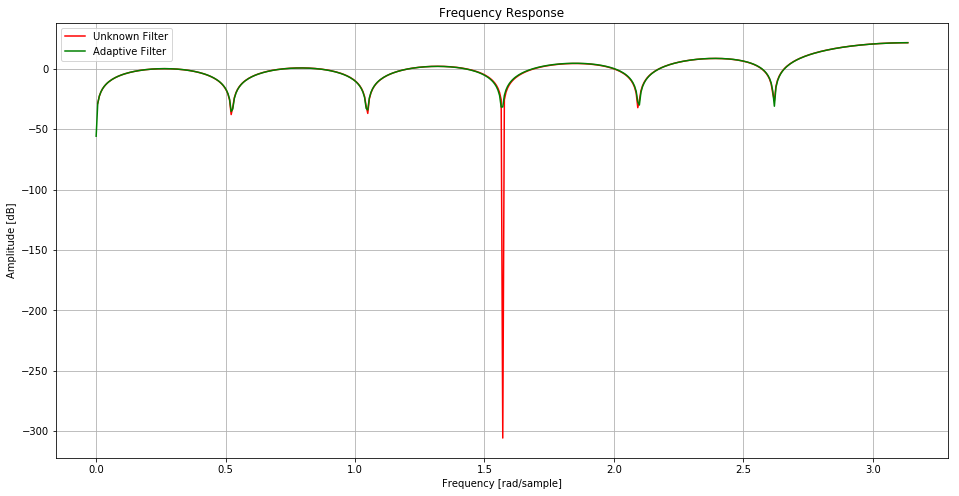

In [66]:
b, a = [1] + list(np.zeros(11)) + [-1], [1, 1] 
wf_model, h_model = signal.freqz(model.coef_vector[-1])
wf_unk, h_unk = signal.freqz(b=b, a=a)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(16,8))
ax.plot(wf_unk, 20 * np.log10(abs(h_unk)), 'r', label='Unknown Filter')
ax.plot(wf_model, 20 * np.log10(abs(h_model)), 'g', label='Adaptive Filter')
ax.set_ylabel('Amplitude [dB]'), ax.set_title('Frequency Response')
ax.set_xlabel('Frequency [rad/sample]')
ax.grid(True)
ax.legend()

if output_filepath is not None:        
    fig.savefig(output_filepath + 'd_frequency_response.jpg'.format(frac), bbox_inches = 'tight')

## Problem 27

For the input signal described in problem 8, derive the autocorrelation matrix of order one ($2 \times 2$). Apply the DCT and the normalization to $\textbf{R}$ in order to generate $\hat{\textbf{R}} = \Sigma^{-2}\textbf{R}\textbf{T}^T$. Compare the eigenvalue spreads of $\textbf{R}$ and $\hat{\textbf{R}}$.} 

The input signal $x(k)$ is given by 

$$x(k) = g(k)*n_x(k)$$

where $n_x(k)$ is a white noise with variance $\sigma_x^2 = 0.5$ and $g(k)$ is the impulse response of the following filter 

$$G(z)  = \frac{z}{z-0.9}$$

Consequently, $x(k)$ can be expressed as 

$$x(k) = 0.9x(k-1) + n_x(k)$$ 

According to Equation 2.83, yields the following autocorrelation function: 

$$r(l) = \frac{0.9^{|l|}}{1-0.9^2} \sigma_x^2 $$

where we have $r(0) = 2.63$ and $r(1) = 2.37$. In the case of a $2 \times 2$ autocorrelation matrix, we have 



In [31]:
from scipy.linalg import toeplitz

sigma_x2 = .5
sigma_n2 = 1e-3
N = 2
r = lambda l, sigma_n2: (0.9**abs(l))*sigma_n2/(1-0.9**2)
R = toeplitz([r(l, sigma_x2) for l in np.arange(N)])
print ('R: ', R)
print ('eig: ', np.linalg.eigvals(R))
print ('Cond: ', np.max(np.linalg.eigvals(R))/np.min(np.linalg.eigvals(R)))
print ('Spread: ', np.max(np.linalg.eigvals(R))-np.min(np.linalg.eigvals(R)))
print ('Trace:', np.trace(R))

def getDCTMatrix(size):
    '''Calculate the square DCT transform matrix. Results are 
    equivalent to Matlab dctmtx(n) with 64 bit precision.'''
    DCTmx = np.array(range(size),np.float64).repeat(size).reshape(size,size)
    DCTmxT = np.pi * (DCTmx.transpose()+0.5) / size
    DCTmxT = (1.0/np.sqrt( size / 2.0)) * np.cos(DCTmx * DCTmxT)
    DCTmxT[0] = DCTmxT[0] * (np.sqrt(2.0)/2.0)
    return DCTmxT
T = getDCTMatrix(N)
sigma_2 = 1/(1e-12+r(0, sigma_x2))*np.eye(N)
R_hat = sigma_2@T@R@np.transpose(T)
print ('R_hat: ', R_hat)
print ('eig: ', np.linalg.eigvals(R_hat))
print ('Cond: ', np.max(np.linalg.eigvals(R_hat))/np.min(np.linalg.eigvals(R_hat)))
print ('Spread: ', np.max(np.linalg.eigvals(R))-np.min(np.linalg.eigvals(R)))

R:  [[2.63157895 2.36842105]
 [2.36842105 2.63157895]]
eig:  [5.         0.26315789]
Cond:  19.00000000000001
Spread:  4.736842105263159
Trace: 5.263157894736843
R_hat:  [[1.90000000e+00 1.11022302e-16]
 [1.59594560e-16 1.00000000e-01]]
eig:  [1.9 0.1]
Cond:  19.00000000000001
Spread:  4.736842105263159


## Problem 31 and 32

In [2]:
n_ensembles = 100   # number of realizations within the ensemble
K = 500             # number of iterations (signal length)
H = np.array([0.32+0.21j,-0.3+0.7j,0.5-0.8j,0.2+0.5j])    
w_o = H             # Unknown system
sigma_n2 = .04      # noise power
N = 4               # Number of coefficients of the adaptive filter
mu = .1            # Convergence factor (step) (0 < mu < 1)
gamma = 1e-12       # small positive number to avoid singularity

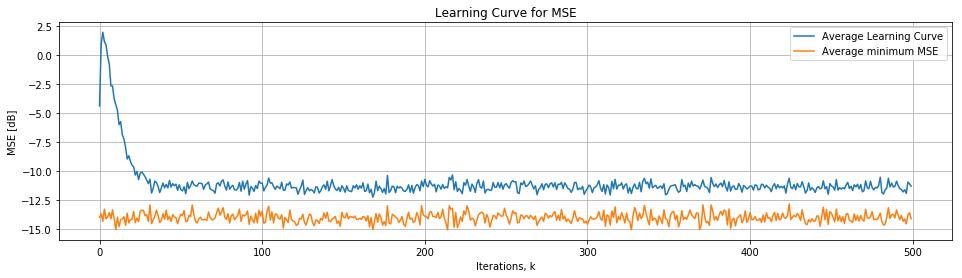

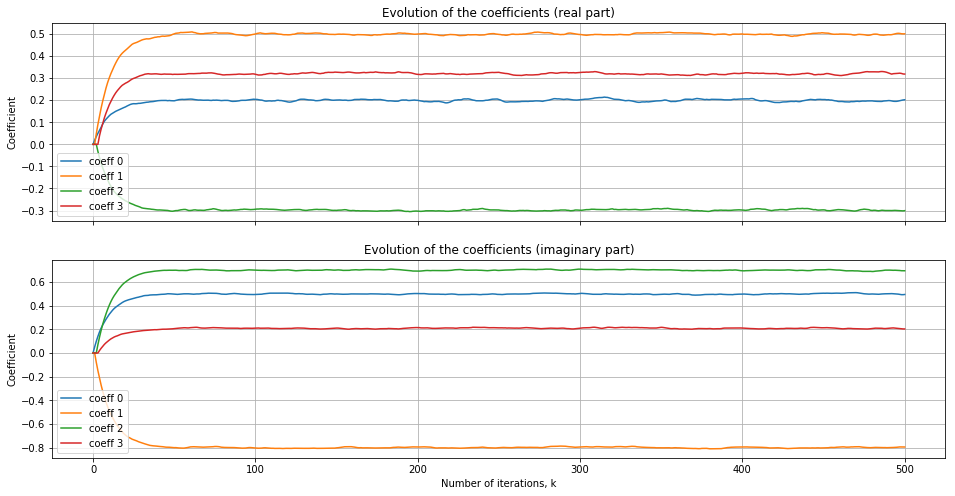

In [9]:
# output_filepath, L = './Outputs/Chap_4/Exercise_31/', 1
output_filepath, L = './Outputs/Chap_4/Exercise_31/', 4

W = np.ones([n_ensembles, K+1, N], dtype=complex) 
MSE = np.zeros([n_ensembles, K]) # MSE vector for each realization
MSE_min = np.zeros([n_ensembles, K]) # Minimum MSE for each realization 

for ensemble in np.arange(n_ensembles):    
    d = np.zeros([K], dtype=complex) # Desired signal

    # Creating the input signal (normalized)        
    x = (np.sign(np.random.randn(K)) + j*np.sign(np.random.randn(K)))/np.sqrt(2) # Complex signal
    n = np.sqrt(sigma_n2/2)*(np.random.normal(size=K)+j*np.random.normal(size=K)) # Complex noise
    sigma_x2 = np.var(x) # signal power = 1

    # Creating a tapped version of x with a N-sized window 
    prefixed_x = np.append(np.zeros([N-1]), x)
    X_tapped = rolling_window(prefixed_x, N)

    for k in np.arange(K):        
        d[k] = np.dot(np.conj(w_o), X_tapped[k])+n[k]       

    init_coef = W[ensemble][0]
    filter_order = N-1    

    lms = AffineProjection(step=mu, filter_order=filter_order, init_coef=init_coef, gamma=gamma, memory_length=L)
    lms.fit(d, x)     

    W[ensemble] = lms.coef_vector
    MSE[ensemble] = MSE[ensemble] + np.absolute(lms.error_vector)**2
    MSE_min[ensemble] = MSE_min[ensemble] + np.absolute(n)**2

W_av = np.sum(W, axis=0)/n_ensembles
MSE_av = sum(MSE, 2)/n_ensembles
MSEmin_av = np.sum(MSE_min, axis=0)/n_ensembles

# Generating plots    
generate_learning_plots(K, N, MSE_av, MSEmin_av, W_av, w_o, output_filepath=output_filepath, algorithm='AffineProjection_L'+str(L))